# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

Also notice, you may be able to use only parts of this notebook (for example certain coding portions or the data) without completing all parts and still meet all requirements of the capstone project.

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
import torchvision.models as models
import numpy as np
from glob import glob

# load filenames for human and dog images
#human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("app/data/dog_images/*/*/*"))

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("app/data/dog_images/train/*/"))]
dog_breeds = len(dog_names)

# print number of images in each dataset
print('There are %d total dog categories.' % len(dog_names))
#print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 133 total dog categories.
There are 8351 total dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("app/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


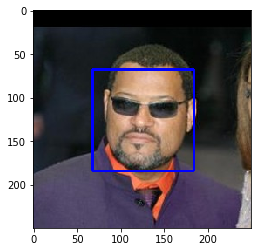

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(r"C:\Users\Ahmed\AppData\Local\conda\conda\envs\deep-learning\Lib\site-packages\cv2\data\haarcascade_frontalface_alt.xml")

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()


Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
```
99.00% percentage of the first 100 images in human_files have a detected human face.
18.00% percentage of the first 100 images in dog_files have a detected human face.
```

In [5]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Vectorize the face dectector function
vfunc = np.vectorize(face_detector)


# Detect faces in both sets
human_faces = vfunc(human_files_short)
dog_faces = vfunc(dog_files_short)

human_face_detection_percentage=sum(human_faces)/len(human_faces)*100
dog_face_detection_percentage=sum(dog_faces)/len(dog_faces)*100

# Calculate and print percentage of faces in each set
print('{:.2f}% percentage of the first 100 images in human_files have a detected human face.'.format(human_face_detection_percentage))
print('{:.2f}% percentage of the first 100 images in dog_files have a detected human face.'.format(dog_face_detection_percentage))

99.00% percentage of the first 100 images in human_files have a detected human face.
18.00% percentage of the first 100 images in dog_files have a detected human face.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__  There are different ways to detect face using Python OpenCV. It already has two pre-trained face detection classifiers, which can readily be used in a program. The two classifiers are:

* Haar Classifier and
* Local Binary Pattern(LBP) classifier.

The following blog discuss about this classifer in details https://www.datacamp.com/community/tutorials/face-detection-python-opencv

The more accurate OpenCV face detector is deep learning based, and in particular, utilizes the Single Shot Detector (SSD) framework with ResNet as the base network. https://www.pyimagesearch.com/2018/02/26/face-detection-with-opencv-and-deep-learning/

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [6]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [VGG16](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained VGG16 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

#use_cuda=False

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
    
print(VGG16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

### Making Predictions with VGG16

Getting the 4D tensor ready for VGG16, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to VGG16, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from PIL import Image
import torchvision.transforms as transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

In [10]:
from PIL import Image
import torchvision.transforms as transforms

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
   transforms.Resize(256),
   transforms.CenterCrop(224),
   transforms.ToTensor(),
   normalize
])

def VGG16_predict(img_path):
    '''
    Use pre-trained densenet161 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to densenet161 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    # loads RGB image as PIL.Image.Image type
    img = Image.open(img_path)
    
    img_tensor = preprocess(img).cuda()
    img_tensor.unsqueeze_(0)
    
    fc_out = VGG16(img_tensor)
    value, index = torch.max(fc_out, 1)
    
    
    
    return np.asscalar(index.cpu().data[0].numpy()) # predicted class index

print(VGG16_predict(dog_files[1200]))


258


### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG16 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [11]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    prediction = VGG16_predict(img_path)
    return ((prediction <= 268) & (prediction >= 151))

print(dog_detector(human_files[0]))
print(dog_detector(dog_files[0]))

False
True


### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [12]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

# Vectorize the face dectector function
dog_vfunc = np.vectorize(dog_detector)

# Detect dogs in both sets
human_dogs = dog_vfunc(human_files_short)
dog_dogs = dog_vfunc(dog_files_short)

human_face_detection_percentage=sum(human_dogs)/len(human_dogs)*100
dog_face_detection_percentage=sum(dog_dogs)/len(dog_dogs)*100

# Calculate and print percentage of faces in each set
print('{:.2f}% of the images in human_files_short have a detected dog.'.format(human_face_detection_percentage))
print('{:.2f}% of the images in dog_files_short have a detected dog.'.format(dog_face_detection_percentage))

0.00% of the images in human_files_short have a detected dog.
94.00% of the images in dog_files_short have a detected dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
## TODO: Specify data loaders
import os
import torch
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transform={
    'test':    transforms.Compose([
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.ToTensor(),
               normalize
                ]),

    'train':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ]),

    'valid':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ])
        }

data_dir='dog_images/'

data_scratch={x:datasets.ImageFolder(data_dir+x, transform=transform[x])
             for x in ['train','test','valid']}

#train_data=datasets.ImageFolder(data_dir+'/train', transform=transform['train'])
#valid_data=datasets.ImageFolder(data_dir+'/valid', transform=valid_transform['valid'])
#test_data=datasets.ImageFolder(data_dir+'/test', transform=test_transform['test'])

batch_size=32
num_workers=0

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#    shuffle=True,num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)

loaders_scratch={
    x:torch.utils.data.DataLoader(data_scratch[x], batch_size=batch_size,
    shuffle=True,num_workers=num_workers)
    for x in ['train','test','valid'] 
    }

(224, 224, 3)


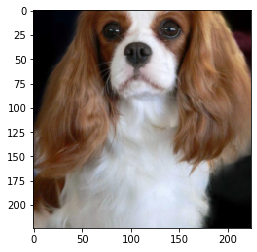

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
train_image = images[0].numpy().transpose((1, 2, 0)) # convert images to numpy for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
train_image = std * train_image + mean
train_image = np.clip(train_image, 0, 1)
#plt.imshow(np.transpose(train_image, (1, 2, 0)))
print(train_image.shape)
plt.imshow(train_image)

torch.Size([3, 224, 224])
(224, 224, 3)


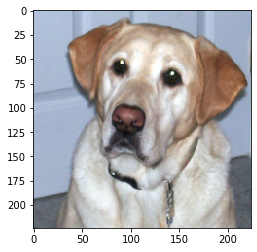

In [15]:
dataiter = iter(loaders_scratch['test'])
images, labels = dataiter.next()
print(images[0].shape)
test_image = images[0].numpy().transpose((1, 2, 0)) # convert images to numpy for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
test_image = std * test_image + mean
test_image = np.clip(test_image, 0, 1)
#plt.imshow(np.transpose(train_image, (1, 2, 0)))
print(test_image.shape)
plt.imshow(test_image)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ For classification task from images, we have used CNN structure as given below.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        #convolutional layer (sees 224x224x3 tensor)
        self.conv1=nn.Conv2d(3,32,3,padding=1)
        #convolutional layer (sees 56x56x32 tensor)
        self.conv2=nn.Conv2d(32,64,3,padding=1)
        #convolutional layer (sees 14x14x64 tensor)
        self.conv3=nn.Conv2d(64,128,3,padding=1)
        #convolutional layer (sees 7x7x128 tensor)
        self.conv4=nn.Conv2d(128,256,3,padding=1)
    
        self.pool4=nn.MaxPool2d(4,4)
        self.pool2=nn.MaxPool2d(2,2)
        self.poolavg=nn.AvgPool2d(7,7)
        
        #linear layer (256->200)
        self.fc1=nn.Linear(256,200)
        #linear layer (200->133)
        self.fc2=nn.Linear(200,dog_breeds)
        self.dropout=nn.Dropout(0.5)
        
        
    
    def forward(self, x):
        ## Define forward behavior
        x=self.pool4(F.relu(self.conv1(x)))
        x=self.pool4(F.relu(self.conv2(x)))
        x=self.pool2(F.relu(self.conv3(x)))
        x=self.poolavg(F.relu(self.conv4(x)))
        x=x.view(-1,256)
        x=self.dropout(x)
        x=self.fc1(x)
        x=self.dropout(x)
        x=self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

print(model_scratch)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (poolavg): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (fc1): Linear(in_features=256, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=133, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


### Compile the Model

In [17]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()


### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(),lr=0.001)

# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size=10, gamma=0.1)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [18]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                    # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


# train the model
model_scratch = train(30, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pth')




Epoch: 1 	Training Loss: 4.886958 	Validation Loss: 4.874590
Validation loss decreased (inf --> 4.874590).  Saving model ...
Epoch: 2 	Training Loss: 4.826981 	Validation Loss: 4.729594
Validation loss decreased (4.874590 --> 4.729594).  Saving model ...
Epoch: 3 	Training Loss: 4.704970 	Validation Loss: 4.628124
Validation loss decreased (4.729594 --> 4.628124).  Saving model ...
Epoch: 4 	Training Loss: 4.653262 	Validation Loss: 4.563889
Validation loss decreased (4.628124 --> 4.563889).  Saving model ...
Epoch: 5 	Training Loss: 4.538792 	Validation Loss: 4.492177
Validation loss decreased (4.563889 --> 4.492177).  Saving model ...
Epoch: 6 	Training Loss: 4.441600 	Validation Loss: 4.427394
Validation loss decreased (4.492177 --> 4.427394).  Saving model ...
Epoch: 7 	Training Loss: 4.373069 	Validation Loss: 4.331128
Validation loss decreased (4.427394 --> 4.331128).  Saving model ...
Epoch: 8 	Training Loss: 4.308114 	Validation Loss: 4.201925
Validation loss decreased (4.33112

### Load the Model with the Best Validation Loss

In [19]:
# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pth'))

<All keys matched successfully>

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [20]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.119640


Test Accuracy: 25% (209/836)


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [21]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
## TODO: Specify data loaders
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transform={
    'test':    transforms.Compose([
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.ToTensor(),
               normalize
                ]),

    'train':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ]),

    'valid':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ])
        }

data_dir='dog_images/'

data_transfer={x:datasets.ImageFolder(data_dir+x, transform=transform[x])
             for x in ['train','test','valid']}

#train_data=datasets.ImageFolder(data_dir+'/train', transform=transform['train'])
#valid_data=datasets.ImageFolder(data_dir+'/valid', transform=valid_transform['valid'])
#test_data=datasets.ImageFolder(data_dir+'/test', transform=test_transform['test'])

batch_size=32
num_workers=0

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#    shuffle=True,num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)

loaders_transfer={
    x:torch.utils.data.DataLoader(data_transfer[x], batch_size=batch_size,
    shuffle=True,num_workers=num_workers)
    for x in ['train','test','valid'] 
    }

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [22]:
### TODO: Define your architecture.
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad=False

from collections import OrderedDict

model_transfer.classifier[6]=nn.Linear(model_transfer.classifier[6].in_features,dog_breeds)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
#use_cuda=False

# move model to GPU if CUDA is available
if use_cuda:
    model_transfer = model_transfer.cuda()

    
    
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [23]:
print(model_transfer.state_dict().keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


In [24]:
model_transfer.state_dict().get('classifier.6.weight')

tensor([[ 0.0130,  0.0010, -0.0097,  ..., -0.0037,  0.0047, -0.0067],
        [-0.0085,  0.0132, -0.0065,  ..., -0.0077, -0.0089,  0.0005],
        [-0.0075,  0.0013, -0.0093,  ...,  0.0143,  0.0134, -0.0067],
        ...,
        [-0.0133, -0.0012,  0.0110,  ..., -0.0129, -0.0067,  0.0111],
        [-0.0120,  0.0094,  0.0068,  ..., -0.0155, -0.0145, -0.0003],
        [-0.0070, -0.0082,  0.0126,  ...,  0.0133,  0.0086,  0.0041]],
       device='cuda:0')

### Compile the Model

In [25]:
### TODO: Compile the model.
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.classifier[6].parameters(),lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=4, gamma=0.1)

### Train the Model

In [26]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train_transfer(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path,breeds,architecture ):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                    # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            
        # calculate average losses
        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            checkpoint={'architecture':architecture,
                       'breeds':breeds,
                       'weights': model.state_dict().get('classifier.6.weight'),
                       'bias': model_transfer.state_dict().get('classifier.6.bias')}
            torch.save(checkpoint, save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


In [27]:
### TODO: Train the model.
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pth')

Epoch: 1 	Training Loss: 1.175554 	Validation Loss: 0.471166
Validation loss decreased (inf --> 0.471166).  Saving model ...
Epoch: 2 	Training Loss: 0.451125 	Validation Loss: 0.488894
Epoch: 3 	Training Loss: 0.375342 	Validation Loss: 0.439082
Validation loss decreased (0.471166 --> 0.439082).  Saving model ...
Epoch: 4 	Training Loss: 0.324845 	Validation Loss: 0.443251
Epoch: 5 	Training Loss: 0.308662 	Validation Loss: 0.444693
Epoch: 6 	Training Loss: 0.264535 	Validation Loss: 0.472975
Epoch: 7 	Training Loss: 0.248381 	Validation Loss: 0.452258
Epoch: 8 	Training Loss: 0.247942 	Validation Loss: 0.455164
Epoch: 9 	Training Loss: 0.265906 	Validation Loss: 0.463222
Epoch: 10 	Training Loss: 0.249253 	Validation Loss: 0.485396


### Load the Model with the Best Validation Loss

In [28]:
def load_transfer( use_cuda, save_path,breeds,architecture ):
    checkpoint = torch.load(save_path)
    structure = checkpoint['architecture']
    if structure=='VGG16':
        model_transfer = models.vgg16(pretrained=True)
    elif structure=='VGG19':
        model_transfer = models.vgg19(pretrained=True)
    else:
        print("Wrong Model")
    for param in model_transfer.parameters():
        param.requires_grad=False
    breeds=checkpoint['breeds']
    model_transfer.classifier[6]=nn.Linear(model_transfer.classifier[6].in_features,breeds)
    model_transfer.state_dict()['classifier.6.weight']=checkpoint['weights']
    model_transfer.state_dict()['classifier.6.bias']=checkpoint['bias']
    if use_cuda:
        model_transfer = model_transfer.cuda()
    return model_transfer
    
    

In [29]:
### TODO: Load the model weights with the best validation loss.
model_transfer = models.vgg16(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad=False

#from collections import OrderedDict

model_transfer.classifier[6]=nn.Linear(model_transfer.classifier[6].in_features,dog_breeds)

#model_transfer.=classifier

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pth'))
if use_cuda:
    model_transfer = model_transfer.cuda()

In [30]:
for param in model_transfer.parameters():
    print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [31]:
print(model_transfer.state_dict().keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


In [32]:
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [33]:
### TODO: Calculate classification accuracy on the test dataset.
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.491639


Test Accuracy: 84% (708/836)


### Predict Dog Breed with the Model

In [34]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    img_tensor = preprocess(img).cuda()
    img_tensor.unsqueeze_(0)
    
    fc_out = model_transfer(img_tensor)
    value, index = torch.max(fc_out, 1)
    
    
    
    return class_names[np.asscalar(index.cpu().data[0].numpy())]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [35]:
#torch.cuda.empty_cache()

In [36]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
## TODO: Specify data loaders
import os
import torch
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
transform={
    'test':    transforms.Compose([
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.ToTensor(),
               normalize
                ]),

    'train':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ]),

    'valid':   transforms.Compose([
               transforms.RandomRotation(10),
               transforms.Resize(256),
               transforms.CenterCrop(224),
               transforms.RandomHorizontalFlip(),
               transforms.ToTensor(),
               normalize
                ])
        }

data_dir='dog_images/'

data_transfer={x:datasets.ImageFolder(data_dir+x, transform=transform[x])
             for x in ['train','test','valid']}

#train_data=datasets.ImageFolder(data_dir+'/train', transform=transform['train'])
#valid_data=datasets.ImageFolder(data_dir+'/valid', transform=valid_transform['valid'])
#test_data=datasets.ImageFolder(data_dir+'/test', transform=test_transform['test'])

batch_size=32
num_workers=0

#train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#    shuffle=True,num_workers=num_workers)
#valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#    shuffle=True,num_workers=num_workers)

loaders_transfer={
    x:torch.utils.data.DataLoader(data_transfer[x], batch_size=batch_size,
    shuffle=True,num_workers=num_workers)
    for x in ['train','test','valid'] 
    }

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [37]:
### TODO: Define your architecture.
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


model_transfer2 = models.vgg19(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad=False

from collections import OrderedDict

model_transfer2.classifier[6]=nn.Linear(model_transfer2.classifier[6].in_features,dog_breeds)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
#use_cuda=False

# move model to GPU if CUDA is available
if use_cuda:
    model_transfer2 = model_transfer2.cuda()

    
    
print(model_transfer2)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### (IMPLEMENTATION) Compile the Model

In [38]:
### TODO: Compile the model.
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer2.classifier[6].parameters(),lr=0.001)
# Decay LR by a factor of 0.1 every 4 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=4, gamma=0.1)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [39]:
### TODO: Train the model.
model_transfer2 = train(10, loaders_transfer, model_transfer2, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer2.pth')

RuntimeError: CUDA out of memory. Tried to allocate 392.00 MiB (GPU 0; 6.00 GiB total capacity; 3.96 GiB already allocated; 351.82 MiB free; 228.07 MiB cached)

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [ ]:
### TODO: Load the model weights with the best validation loss.
model_transfer2 = models.vgg19(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad=False

#from collections import OrderedDict

model_transfer2.classifier[6]=nn.Linear(model_transfer2.classifier[6].in_features,dog_breeds)

#model_transfer.=classifier

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer2.load_state_dict(torch.load('model_transfer2.pth'))
if use_cuda:
    model_transfer2 = model_transfer2.cuda()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [ ]:
### TODO: Calculate classification accuracy on the test dataset.
test(loaders_transfer, model_transfer2, criterion_transfer, use_cuda)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [41]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    img_tensor = preprocess(img).cuda()
    img_tensor.unsqueeze_(0)
    
    fc_out = model_transfer(img_tensor)
    value, index = torch.max(fc_out, 1)
    
    return class_names[np.asscalar(index.cpu().data[0].numpy())]
    
# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer_topk(img_path,model,k):
    # load the image and return the predicted breed
    img = Image.open(img_path)
    
    img_tensor = preprocess(img).cuda()
    img_tensor.unsqueeze_(0)
    
    fc_out = model(img_tensor)
    probability = F.softmax(fc_out.data,dim=1)
    value, index = torch.topk(probability, k)
    
    
    
    return index.cpu().data[0].numpy(), value.cpu().data[0].numpy()    

In [42]:


breeds, values= predict_breed_transfer_topk('images/Labrador_retriever_06449.jpg', model_transfer, 5)

In [43]:
print(breeds)
print(values)

[95 43 77 67 24]
[0.9715053  0.01164197 0.00655318 0.0053242  0.00208635]


In [44]:
classes = [class_names[c] for c in breeds]
print(classes)

['Labrador retriever', 'Cane corso', 'Great dane', 'Flat-coated retriever', 'Black and tan coonhound']


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [45]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    breed= predict_breed_transfer(img_path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # since the dog detector worked better, and we don't have 
    # access to softmax probabilities from dog and face detectors
    # we'll first check for dog detection, and only if there are no dogs
    # detected we'll check for humans
    if dog_detector(img_path):
        print('Hello Dog!')
        plt.figure()
        plt.imshow(img)
        print('You look like a {}.'.format(breed))
        
    elif face_detector(img_path):
        print('Hello human!')
        plt.figure()
        plt.imshow(img)
        print('If you were a dog, you\'d be a {}.'.format(breed))
    else:
        print('Could not detect dogs or humans in image.')
        plt.figure()
        plt.imshow(img)

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ These are the improvement ideas on this present application:
1. __AUGMENT THE TRAINING DATA__: Augmenting the training and/or validation set might help improve model performance.
1. __DIFFERENT PRETRAINED MODEL__: In our future project, we would like to use other pretrained models such as Densenet, Resnet or Inception. 
1. __OVERLAY DOG EARS ON DETECTED HUMAN HEADS:__ Overlay a Snapchat-like filter with dog ears on detected human heads. You can determine where to place the ears through the use of the OpenCV face detector, which returns a bounding box for the face. If you would also like to overlay a dog nose filter, some nice tutorials for facial keypoints detection exist [here](https://www.kaggle.com/c/facial-keypoints-detection/details/deep-learning-tutorial).
1. __ADD FUNCTIONALITY FOR DOG MUTTS__: Currently, if a dog appears 51% German Shephard and 49% poodle, only the German Shephard breed is returned. The algorithm is currently guaranteed to fail for every mixed breed dog. Of course, if a dog is predicted as 99.5% Labrador, it is still worthwhile to round this to 100% and return a single breed; so, you will have to find a nice balance.

Hello Dog!
You look like a Brittany.


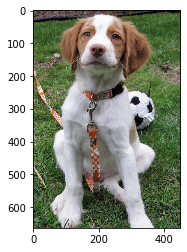

In [46]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.
run_app('images/Brittany_02625.jpg')

Hello Dog!
You look like a Labrador retriever.


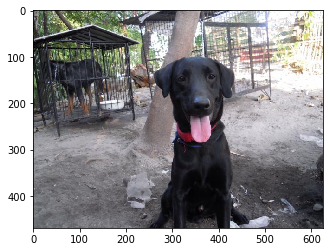

In [47]:
run_app('images/Labrador_retriever_06449.jpg')

Could not detect dogs or humans in image.


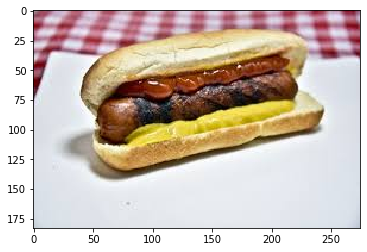

In [48]:
run_app('images/hot_dog2.jpg')

Hello human!
If you were a dog, you'd be a Chinese crested.


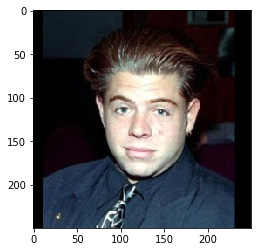

In [49]:
run_app('lfw/Adam_Rich/Adam_Rich_0001.jpg')

Hello human!
If you were a dog, you'd be a Dogue de bordeaux.


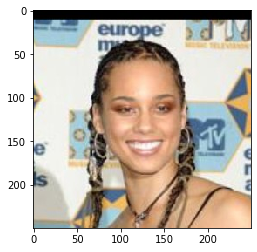

In [50]:
run_app('lfw/Alicia_Keys/Alicia_Keys_0001.jpg')

Could not detect dogs or humans in image.


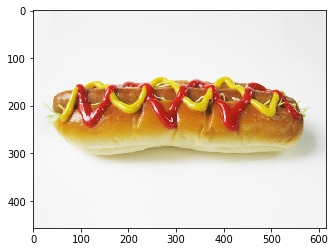

In [51]:
run_app('images/hot_dog1.jpg')

Hello human!
If you were a dog, you'd be a Dogue de bordeaux.


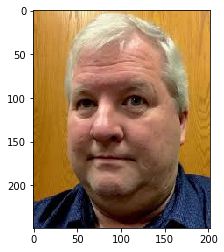

In [52]:
run_app(r'C:\Users\Ahmed\Desktop\brent.jpg')

In [59]:
import os
total=0
count=0
# Set the directory you want to start from
rootDir = 'dog_images/test/'
for dirName, subdirList, fileList in os.walk(rootDir):
    #print('Found directory: %s' % dirName)
    x=dirName.split('/')
    subdir=x[-1]
    #for subname in subdirList:
    for fname in fileList:
        #print('\t%s/%s' % (dirName, fname))
        fileName=dirName+'/'+fname
        total=total+1
        classes = predict_breed_transfer(fileName)
        #print(classes)
        #classes = classes.cpu().data.numpy()[1][0]#convert class integer to flower name
        #title = classes[0] #highest probability class
        if classes!=subdir[4:].replace("_", " "):
            print('miss classified file %s:'%fileName)
            #print(fileName)
            print('predicted class: '+classes)
            count=count+1
print('total misclassification: %d'%count)
print('total test file: %d'%total)


miss classified file dog_images/test/002.Afghan_hound/Afghan_hound_00141.jpg:
predicted class: Cocker spaniel
miss classified file dog_images/test/002.Afghan_hound/Afghan_hound_00146.jpg:
predicted class: English setter
miss classified file dog_images/test/004.Akita/Akita_00244.jpg:
predicted class: Alaskan malamute
miss classified file dog_images/test/004.Akita/Akita_00276.jpg:
predicted class: Finnish spitz
miss classified file dog_images/test/006.American_eskimo_dog/American_eskimo_dog_00471.jpg:
predicted class: Pomeranian
miss classified file dog_images/test/007.American_foxhound/American_foxhound_00535.jpg:
predicted class: Beagle
miss classified file dog_images/test/009.American_water_spaniel/American_water_spaniel_00624.jpg:
predicted class: Boykin spaniel
miss classified file dog_images/test/009.American_water_spaniel/American_water_spaniel_00655.jpg:
predicted class: Curly-coated retriever
miss classified file dog_images/test/011.Australian_cattle_dog/Australian_cattle_dog_00

miss classified file dog_images/test/073.German_wirehaired_pointer/German_wirehaired_pointer_05043.jpg:
predicted class: Wirehaired pointing griffon
miss classified file dog_images/test/073.German_wirehaired_pointer/German_wirehaired_pointer_05060.jpg:
predicted class: Black russian terrier
miss classified file dog_images/test/074.Giant_schnauzer/Giant_schnauzer_05120.jpg:
predicted class: Black russian terrier
miss classified file dog_images/test/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05149.jpg:
predicted class: Irish wolfhound
miss classified file dog_images/test/075.Glen_of_imaal_terrier/Glen_of_imaal_terrier_05164.jpg:
predicted class: Chinese crested
miss classified file dog_images/test/076.Golden_retriever/Golden_retriever_05248.jpg:
predicted class: Nova scotia duck tolling retriever
miss classified file dog_images/test/078.Great_dane/Great_dane_05329.jpg:
predicted class: Boston terrier
miss classified file dog_images/test/079.Great_pyrenees/Great_pyrenees_05365.jpg:
p

In [54]:
import os
 
# Set the directory you want to start from
rootDir = 'dog_images/test/'
for dirName, subdirList, fileList in os.walk(rootDir):
    #print('Found directory: %s' % dirName)
    x=dirName.split('/')
    subdir=x[-1]
    print(subdir[4:].replace("_", " "))


Affenpinscher
Afghan hound
Airedale terrier
Akita
Alaskan malamute
American eskimo dog
American foxhound
American staffordshire terrier
American water spaniel
Anatolian shepherd dog
Australian cattle dog
Australian shepherd
Australian terrier
Basenji
Basset hound
Beagle
Bearded collie
Beauceron
Bedlington terrier
Belgian malinois
Belgian sheepdog
Belgian tervuren
Bernese mountain dog
Bichon frise
Black and tan coonhound
Black russian terrier
Bloodhound
Bluetick coonhound
Border collie
Border terrier
Borzoi
Boston terrier
Bouvier des flandres
Boxer
Boykin spaniel
Briard
Brittany
Brussels griffon
Bull terrier
Bulldog
Bullmastiff
Cairn terrier
Canaan dog
Cane corso
Cardigan welsh corgi
Cavalier king charles spaniel
Chesapeake bay retriever
Chihuahua
Chinese crested
Chinese shar-pei
Chow chow
Clumber spaniel
Cocker spaniel
Collie
Curly-coated retriever
Dachshund
Dalmatian
Dandie dinmont terrier
Doberman pinscher
Dogue de bordeaux
English cocker spaniel
English setter
English springer span